In [1]:
using Pkg
Pkg.activate("NB06");

  Activating project at `~/Meine Dokumente/GitHub/Elemente-der-Datenanalyse-und-der-Kuenstlichen-Intelligenz/Notebooks/06/NB06`


In [2]:
using Flux # Interface für neuronale Netze
using BytePairEncoding # Tokenisierer
using JLD2 # Julia Daten laden
using TSne # Für das Plotting von hochdimensionalen Datenpunkten
using LinearAlgebra, StatsBase, Plots, Random, ProgressMeter

# Large Language Models

In diesem Notebook wollen wir ein Large Language Model (LLM) implementieren. 

Das Notebook gliedert sich dabei in mehrere Abschnitte:

* Zunächt laden wir einen Textdatensatz und zerlegen ihn in Token.
* Als Datensatz nehmen wir die [Transkripte aus 393 Spongebob Episoden (auf englisch)](https://www.kaggle.com/datasets/mikhailgaerlan/spongebob-squarepants-completed-transcripts). Die Daten sind von [Kaggle](https://www.kaggle.com).
* Dann untersuchen wir die Häufigkeiten der einzelnen Token, um ein Gefühl für die Struktur des Textes zu bekommen.
* Anschließend implementieren wir das Attention Modell.
* Das Attention Modell ist der zentrale Baustein unseres LLMs namens **SpongeGPT**.
* Schließlich trainieren wir SpongeGPT auf dem Text und schauen das Ergebnis an.
* Zuletzt untersuchen wir die Geometrie der Worteinbettungen, die unser LLM gelernt hat.

Dieses Notebook ist damit mit Abstand das Längste unter den 6 Notebooks.

#### Referenzen

Der Code in diesem Notebook basiert in weiten Teilen auf dem Blog Post [Generative transformer from first principles in Julia](https://liorsinai.github.io/machine-learning/2024/03/23/transformers-gpt.html) von [Lior Sinai](https://liorsinai.github.io). 

Das Youtube-Tutorial [Let’s build GPT: from scratch, in code, spelled out](https://www.youtube.com/watch?v=kCc8FmEb1nY) von [Andrej Karpathy](https://karpathy.ai) ist ebenfalls sehr hilfreich, um zu verstehen, wie der Code funktioniert. 




## Der Datensatz
        
Die Variable `text` im nächsten Code Abschnitt ist ein einzelner `String`, der die gesammelten Transkripte enthält.

In [3]:
##### Laden der Textdaten
ordner = "../text/spongebob"
R = readdir(ordner)
data = map(R) do filename
    filepath = join([ordner, "/", filename])
    open(filepath) do file
        read(file, String)
    end
end;
text = "";
for j = 1:length(data); text = join([text, data[j]]) end;

## Der Tokenisierer

Damit unser LLM mit dem Text arbeiten kann, müssen wir ihn in Token zerlegen.

Es gibt viele verschiedene Tokenisierer, also Methoden den Text in Token zu zerlegen.

Wir verwenden den Tokenisierer von Chat-GPT2.

Damit wir den Tokenisierer nicht selber implementieren müssen, laden wir ihn aus dem `BytePairEncoding` Package. 

In [4]:
tokenizer = BytePairEncoding.load_tiktoken_encoder("gpt2");

Schauen wir, wie sich der Text "Patrick lives in Bikini Bottom." in Token zerlegt.

In [5]:
input = "Patrick lives in Bikini Bottom."
tk = tokenizer(input)

7-element Vector{Int64}:
 32719
  3161
   288
   348
 35543
 24531
    14

Wie wir sehen sind die Token durch ganze Zahlen kodiert. 

Die Funktion `tokenizer.decode` dekodiert dann die Token zurück in Text.

In [6]:
tokenizer.decode(tk) |> println
for t in tk 
    println("Token: (", tokenizer.decode([t]), ") => ", t)
end

Patrick lives in Bikini Bottom.
Token: (Patrick) => 32719
Token: ( lives) => 3161
Token: ( in) => 288
Token: ( B) => 348
Token: (ikini) => 35543
Token: ( Bottom) => 24531
Token: (.) => 14


Die Folge von ganzen Zahlen, die wir erhalten, wenn wir den kompletten Text tokenisieren, nennen wir `corpus`:

In [7]:
corpus = tokenizer(text);

Schauen wir uns den Anfang des Textes an, einmal als Token und einmal als Text:

In [8]:
snippet = corpus[1:15]
println(snippet)
println("\n bedeutet")
println(tokenizer.decode(snippet))

[199, 59, 465, 4472, 6141, 380, 9075, 14, 351, 1649, 339, 3249, 804, 3962, 14]

 bedeutet

[The episode begins at Mrs. Puff's Boating School.


## Das Vokabular

Die Menge aller Token bildet das Vokabular. 

Das Vokabular ist bereits im `tokenizer` eingebaut: 

In [9]:
vocabulary = string.(tokenizer.vocab.list)
vocab_size = length(vocabulary)
vocab_size, length(corpus)

(50257, 1428294)

Wie wir sehen umfasst das Vokabular 50.257 Token, während der gesamte Text aus 1.428.294 Token besteht. 

## Wort-Statistiken

Als Nächstes erstellen wir eine Statistik, welches Token wie häufig auftritt. 

In [10]:
stats = countmap(corpus)
tks = collect(keys(stats)); counts = collect(values(stats));

Z.B. sind die häufigsten Token wie folgt (getrennt durch " | "):

In [11]:
σ = sortperm(counts; rev = true)[1:18]
frequent_tks = tks[σ]

println("\n Die häufigsten Token sind:\n")
for i in frequent_tks
    tk = vocabulary[i]
    tk == "\n" ? print("\\n", " | ") : print(tk, " | ")
end
println("\n ")


 Die häufigsten Token sind:

. | , | \n | : |  the | ] |  [ | ! | Bob |  and |  to |  a |  I | Sp | onge | 's | ? |  you | 
 


Und hier als Histogramm:

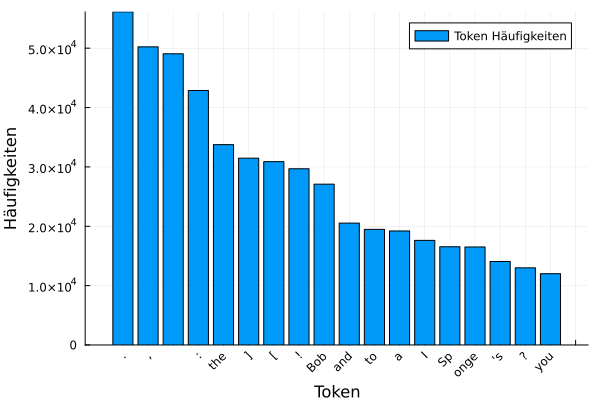

In [12]:
plot(counts[σ], seriestype = :bar,
     xticks = (1:30, vocabulary[frequent_tks]), xrotation = 45, size = (600, 400),
     label = "Token Häufigkeiten", xlabel = "Token", ylabel = "Häufigkeiten")

## Attention Modell

Nachdem wir nun den Text ausführlich studiert haben, widmen wir uns der Implementierung des LLM, das wir auf dem Text trainieren möchten.

Der zentrale Baustein ist der Attention-Mechanismus
    $$\mathrm{Attention}(Q,K,V) = V\cdot \mathrm{SoftMax}(K^\top  Q).$$

Hierbei ist, gegeben die Eingabe $X$, 
* $Q = f_Q(X)$,
* $K = f_K(X)$ und 
* $V = f_V(X)$,

wobei $f_Q,f_K,f_V$ neuronale Netze sind. 

Wir wählen, wie oft üblich, lineare Abbildungen für $f_Q,f_K,f_V$. <br>
Im nächsten Code Abschnitt heissen sie `denseQ`, `denseK` und `denseV` (weil lineare Abbildungen auch "dense linear networks" genannt werden):

<img src="img/img1.png" width="500"/>

Wir wollen mit Multi-Head Attention arbeiten. Dazu brauchen wir `nhead`, die Anzahl der Heads, und `denseO`, eine lineare Abbildung, die die Ergebnisse der Heads kombiniert. 
                                                                     

In [13]:
struct Attention
    nhead::Int
    denseQ::Dense
    denseK::Dense
    denseV::Dense
    denseO::Dense
end

# Wir definieren die Parameter, die "trainable" sind:
Flux.@layer Attention trainable = (denseQ, denseK, denseV, denseO)

Um Zeit und Platz im Code zu sparen, definieren wir eine Funktion `Attention` die direkt ein Attention-Modell aufsetzt. Die Eingabe dieser Funktion sind die Anzahl der Heads `nheads`, die Eingabe-Dimension `dim_in` und die Ausgabe-Dimension `dim_out`.

Sei
$$h = \text{dim-head} \cdot \text{nhead}.$$
Die Funktion erzeugt 
$$Q,K,V \in\mathbb R^{h\times(\text{dim-in})  }\quad \text{und}\quad O \in\mathbb R^{(\text{dim-out})\times h  }.$$

In [14]:
function Attention(nhead::Int, dim_in::Int, dim_out::Int)
    if dim_in % nhead != 0
        error("input dimension=$dim_in is not divisible by number of heads=$nhead")
    else
        dim_head = div(dim_in, nhead) # = dim_in / nhead
    end
    
    h = dim_head * nhead
    Q = Dense(dim_in, h; bias = false)
    K = Dense(dim_in, h; bias = false)
    V = Dense(dim_in, h; bias = false)
    O = Dense(h, dim_out)
    Attention(nhead, Q, K, V, O)
end;

Hierbei benutzen wir die Notation von `Flux.jl`:
* `Dense` erzeugt ein lineares Netzwerk
* `bias = false` heisst, dass der Bias Null ist (wir verwenden also lineare Abbildungen der Form $x\mapsto Mx$ und nicht $x\mapsto Mx+b$). 
* Zudem verwenden wir keine Aktivierungsfunktion.

Das Modell `Attention` ist nun definiert.

Jetzt müssen wir implementieren, wie das Modell Eingaben verarbeiten soll. 

Als erstes brauchen wir Masking (Erinnerung: Masking setzt das linke untere Dreieck einer Matrix als $-\infty$).

In [15]:
function apply_mask(M, mask)
    if isnothing(mask)
        return M
    else
        neginf = typemin(eltype(M))
        return ifelse.(mask, M, neginf)
    end
end

apply_mask (generic function with 1 method)

**Beispiel** 
$$
K^\top  Q = \begin{pmatrix}
\langle k_1,q_1\rangle & \langle k_1,q_2\rangle  & \langle k_1,q_3\rangle \\
\langle k_2,q_1\rangle & \langle k_2,q_2\rangle  & \langle k_3,q_3\rangle \\
\langle k_3,q_1\rangle & \langle k_3,q_2\rangle  & \langle k_3,q_3\rangle 
\end{pmatrix} \quad \rightsquigarrow\quad
\mathrm{maskiert}(K^\top  Q) = \begin{pmatrix}
\langle k_1,q_1\rangle & \langle k_1,q_2\rangle & \langle k_1,q_3\rangle \\
 -\infty & \langle k_2,q_2\rangle  & \langle k_2,q_3\rangle\\
-\infty & -\infty  & \langle k_3,q_3\rangle 
\end{pmatrix}.$$

In [16]:
M = randn(Float32, 3,3)

3×3 Matrix{Float32}:
  1.07856   -0.543818  0.316595
  0.338648  -1.65747   0.17093
 -0.370574  -0.47179   0.908898

In [17]:
mask = make_causal_mask(ones(3, 3));
apply_mask(M, mask)

3×3 Matrix{Float32}:
   1.07856   -0.543818  0.316595
 -Inf        -1.65747   0.17093
 -Inf       -Inf        0.908898

Jetzt sind wir bereit den Attention Mechanismus zu implementieren.

Wir definieren wir das Modell $A$ vom Typ `Attention` eine Eingabe `X` verarbeiten soll. 

Die mathematische Formulierung ist 
$$A(X) = \mathrm{Attention}(Q,K,V) = V\cdot \mathrm{SoftMax}(K^\top  Q),$$
wobei 
$$\mathrm{denseQ}(X) = Q, \quad \mathrm{denseK}(X) = K,\quad \mathrm{denseV}(X) = V.$$

Die folgende Implementierung macht es zudem möglich *Batches* zu verarbeiten. Batches sind Eingabedaten, die parallel verarbeitet werden können.

In [18]:
function (A::Attention)(X; mask = nothing)
    nhead = A.nhead
    
    # Berechnung von Q, K und V
    # Q, K, V ∈ ℝ^(d1 x d2 x b),
    # wobei 
    #   * b = Anzahl Batches (siehe unten) und 
    #   * d1 = dh * nheads.
    #   * dh = Dimension der Heads in Multihead Attention
    # Die Heads sind also im ersten Index von Q, K, V encodiert.
    Q, K, V = A.denseQ(X), A.denseK(X), A.denseV(X)
    d1, d2, b = size(Q)
    dh = div(d1, nhead) 
    
    # Wir wollen batched_mul von Flux.jl benutzen.
    # Dazu müssen Q, K, V in (dh x d2 x (nhead * b)-Arrays transformiert werden
    # batched_mul operiert auf den ersten beiden Modes!
    Q = permutedims(reshape(Q, dh, nhead, d2, b), [1, 3, 2, 4])
    K = permutedims(reshape(K, dh, nhead, d2, b), [1, 3, 2, 4])
    V = permutedims(reshape(V, dh, nhead, d2, b), [1, 3, 2, 4])
    Q, K, V = map(x -> reshape(x, size(x, 1), size(x, 2), :), (Q, K, V))
    
    # Jetzt berechnen wir M = mask((K^T Q) / sqrt(dh))
    K_transpose = permutedims(K, (2, 1, 3))
    M = batched_mul(K_transpose, Q) ./ sqrt(dh) 
    M = apply_mask(M, mask) 
    
    # SoftMax auf M = mask((K^T Q) / sqrt(dh))
    scores = softmax(M; dims = 1)
    
    # Zuletzt: Linearkombination der Spalten von V durch scores:
    #scores = reshape(scores, (size(scores, 1), size(scores, 2), batch_size...))
    V = batched_mul(V, scores)
    
    # Zurück in die richtige Form bringen
    V = reshape(V, (size(V, 1), size(V, 2), nhead, b))
    V = permutedims(V, [1, 3, 2, 4])
    V = reshape(V, d1, size(V, 3), size(V, 4))

    return A.denseO(V)
end

## Transformer

Der Kern des Transformer Modells ist der Attention Mechanismus.

Diesen haben wir bereits implementiert.

Um das Transformer Modell zu vervollständigen fügen wir noch Layer Normalisierung-Schichten hinzu. Insgesamt funktioniert under Transformer Modell wie folgt:

$$\text{MultiHead Attention} \rightarrow \text{Layer-Normalisierung} \rightarrow \text{Neuronales Netz} \rightarrow \text{Layer Normalisierung}.$$


In [19]:
struct Transformer
    multihead_attention::Attention    # Attention Mechanismus
    norm_attention::LayerNorm         # Layer-Normalisierung nach Attention
    dense1::Dense                     # Neuronales Netzwerk nach norm_attention
    dense2::Dense                     # Neuronales Netzwerk nach dense1
    norm_feedforward::LayerNorm       # Layer-Normalisierung nach dense2
    dropout::Dropout                  # Dropout
end

Flux.@layer Transformer 

In [20]:
function (T::Transformer)(X; mask = nothing)
    A = T.multihead_attention(X; mask = mask) 
    A = T.dropout(A)
    A = A + X
    A = T.norm_attention(A)           
    
    B = T.dense1(A)                 
    B = T.dense2(B)                
    B = T.dropout(B)
    A = A + B
    
    A = T.norm_feedforward(A)          
    A
end

Die nächste Funktion erstellt einen Transformer für den Input `nhead` (Anzahl Heads), `dim_model` (Dimension der Worteinbettung) und `dim_hidden` (die Dimension des versteckten Layers zwischen `dense1` und `dense2`). 

Dies erzeugt weiter unten einen einfacher zu verstehenden Code.  

In [21]:
function Transformer(nhead, dim_model, dim_hidden;
                        act = relu,
                        pdrop::Float64 = 0.1)
    
    Transformer(Attention(nhead, dim_model, dim_model),
                LayerNorm(dim_model),
                Dense(dim_model, dim_hidden, act),
                Dense(dim_hidden, dim_model),
                LayerNorm(dim_model),
                Dropout(pdrop))
end

Transformer

## Wir bauen ein LLM

Jetzt sind wir bereit unser Transformer Modell zu verwenden, um ein LLM zusammenzubauen. 

**Erinnerung:** Ein LLM funktioniert wie folgt:

<img src="img/img2.png" width="600"/>

Hierbei ist:

* $x\in E$ der (Eingabe-)Prompt,
* $\tau$ der Tokenisierer, der die Eingabe $x$ auf eine Tokenfolge $t = (t_1,\ldots,t_m) = \tau(x)$ abbildet,
* $\varphi$ eine Text-Einbettung, die die Tokenfolge $t$ auf die Einbettungsmatrix $X$ abbildet:
$$X = \begin{pmatrix} 
  \mid && \mid \\
    \varphi(t_1) & \ldots &   \varphi(t_m)\\
  \mid && \mid 
\end{pmatrix} \in\mathbb R^{n_\mathrm{embed} \times m},$$
* $T$ ein Transformer,
* $M$ eine finale Matrixtransformation, genannt Head, der Form 
$M(X) = U \, X \, u \in\mathbb R^r,$
wobei $r$ die Grösse des Vokabulars ist.

Zudem fügen wir noch eine *Position Encoding* Schicht hinzu, die dafür sorgt, dass das Modell sensitiv zur Tokenreihenfolge ist.<br>
(D.h., dass die Position der Token in der Eingabe relevant wird.)

Wir nennen unser LLM 
$$\textbf{SpongeGPT}$$
(Sponge Generative Pretrained Transformer).

In [22]:
struct SpongeGPT
    embedding::Flux.Embedding
    position_encoding::Flux.Embedding
    dropout::Dropout
    blocks::Vector{Transformer}
    head::Dense
    mask::Union{Nothing,AbstractMatrix{Bool}}
end

Flux.@layer SpongeGPT trainable =
    (embedding, position_encoding, dropout, blocks, head)

Die nächste Funktion definiert, wie wir ein SpongeGPT an einer Tokenfolge $t$ auswerten.

Hierbei ist der Head $M(X) = U X$, wobei $U$ trainierbar ist.<br>
(diese Definition ist anders als im Skript, wo wir $M(X) = UXu$ haben. Wir berechnen hier $UX$ anstatt $UXu$, weil uns dies in der Implementierung des Trainingsschritts später hilft).

Die Funktion `SGPT(X)` nimmt als Input eine Tokenfolge $t$ und gibt als Output die Wahrscheinlichkeitsverteilung für das nächste Token. Im Vergleich zu oben führen wir also folgende Unterfunktion aus:

<img src="img/img3.png" width="450"/>

In [23]:
function (SGPT::SpongeGPT)(t::Matrix; mask = SGPT.mask)
    X = SGPT.embedding(t)  # Einbettung φ             
    N = size(X, 2)
    X = X .+ SGPT.position_encoding(1:N) # Position Encoding
    X = SGPT.dropout(X) # Dropout
    
    for Transformer in SGPT.blocks # in unserem Beispiel: 3 blocks T_1, T_2, T_3
        X = Transformer(X; mask = mask)     
    end
     
    # X -> M(X) = UX, Rechtsmultiplikation mit e_r findet später statt.
    # (Wir wollen für das Training später alle Spalten von UX behalten)
    X = SGPT.head(X)
    
    # SoftMax
    probs = softmax(X; dims = 1) 
    
    return probs
end

## Unser Modell: SpongeGPT

Da wir nun alles für unser Modell implementiert haben, können wir es nun berechnen lassen.

Als Hyperparameter wählen wir 
* Kontextgrösse $=128$
* Einbettungsdimension $=64$
* Anzahl der Heads $=4$

Diese Parameter sind Modell-spezifisch und können geändert werden:

In [24]:
context_size = 128
embed_dim = 64
nheads = 4
mask = make_causal_mask(ones(context_size, context_size));

E1 = Embedding(vocab_size => embed_dim)
E2 = Embedding(context_size => embed_dim)
T = [Transformer(4, embed_dim, embed_dim * 4),
     Transformer(4, embed_dim, embed_dim * 4),
     Transformer(4, embed_dim, embed_dim * 4)]
D = Dense(embed_dim, vocab_size);

Definieren wir nun **SpongeGPT** v1.0.

In [61]:
SpongeGPTv1 = SpongeGPT(E1, E2, Dropout(0.1), T, D, mask)

SpongeGPT(
  Embedding(50257 => 64),               # 3_216_448 parameters
  Embedding(128 => 64),                 # 8_192 parameters
  Dropout(0.1),
  [
    Transformer(
      Attention(
        Dense(64 => 64; bias=false),    # 4_096 parameters
        Dense(64 => 64; bias=false),    # 4_096 parameters
        Dense(64 => 64; bias=false),    # 4_096 parameters
        Dense(64 => 64),                # 4_160 parameters
      ),
      LayerNorm(64),                    # 128 parameters
      Dense(64 => 256, relu),           # 16_640 parameters
      Dense(256 => 64),                 # 16_448 parameters
      LayerNorm(64),                    # 128 parameters
      Dropout(0.1),
    ),
    Transformer(
      Attention(
        Dense(64 => 64; bias=false),    # 4_096 parameters
        Dense(64 => 64; bias=false),    # 4_096 parameters
        Dense(64 => 64; bias=false),    # 4_096 parameters
        Dense(64 => 64),                # 4_160 parameters
      ),
      LayerNorm(64),        

Es gibt noch ein kleines Problem in der Art, wie wir unser Modell definiert haben. Ist die Eingabe größer als die Kontextgröße, so wird unser Modell einen Fehler erzeugen. Um dies zu umgehen definieren wir eine Funktion `tail`, die eine Eingabe "abschneidet", wenn sie zu groß ist.

In [26]:
function tail(A, n)
    n = min(n, size(A, 1))
    A[(end-n+1):end, :]
end

tail (generic function with 1 method)

Da wir, um Text zu generieren, unser Modell iterativ ausführen wollen, müssen wir eine `for` Loop bauen. 

Dies packen wir in eine Funktion.

In [27]:
function (model::SpongeGPT)(input::String; max_tokens = 50, context_size = 128)
    
    # Tokenisieren
    t = tokenizer(input)
    t = reshape(Int32.(t), length(t), 1)
    
    for i = 1:max_tokens
        
        # Input zurecht schneiden, wenn zu groß
        t_crop = tail(t, context_size) 
        
        # Mask der richtigen Grösse erstellen
        n = size(t_crop, 1)
        M = isnothing(model.mask) ? nothing : view(model.mask, 1:n, 1:n) 
        
        # Modell auswerten
        probs = model(t_crop; mask = M)
        p = probs[:, end, :]
        next_token = [Int32(sample(Weights(p))) for p in eachcol(p)] 
        
        # Ausgabe des Modells an den Input anhängen
        t = cat(t, next_token; dims = 1)
    end
    
    return tokenizer.decode(t)[1]
end

Wir generieren nun Text mit Hilfe unseres LLM für einen Eingabeprompt.

In [28]:
prompt = "Patrick loves math"

"Patrick loves math"

In [62]:
SpongeGPTv1(prompt; max_tokens = 50) |> print

Patrick loves math andarella Broad sending ½ culletimes operation moaningenemy outlaw Paroriedators Northeast crabs slamsockey steady spawneredith screens retrieval colossal isoLabelapt stab junction removeSuddenly jouraux SiberianEarly Or ste Ok CALLphabetppedactlicks authoredmassive anecdoteESSION valiantreprene Pattyeday

Wie wir sehen, ist der Text noch ein ziemliches Durcheinander. 

Das liegt daran, dass wir unser Modell noch nicht trainiert haben. Dies holen wir jetzt nach.

## Training

Zuerst zerlegen wir die Daten in Trainingsdaten (90%) und Testdaten (10%).

In [30]:
n_val = floor(Int, (0.9) * length(corpus))
train_data = corpus[1:n_val]
test_data = corpus[(n_val+1):end];

Dann definieren wir das empirische Risiko. Die Verlustfunktion $\ell(\hat y, y)$ ist wieder [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy):

$$\ell(\hat y, y) = -\sum_{i=1}^k y_i\cdot \log(\hat y_i),$$

wobei $k$ die Größe des Vokabulars ist.

**Erinnerung:** Die Definition der Cross-Entropy hat folgenden Hintergrund. Wir betrachten eine Zufallsvariable $\hat Y$ auf den $k$ Klassen mit der von unserem Modell berechneten Wahrscheinlichkeitsverteilung $\hat y\in\mathbb R^k$. 

In der Informationstheorie wird die Unsicherheit des Ereignisses $\hat Y=i$ wird mit $\log(1/(\hat y_i)) = -\log(\hat y_i)$ modelliert. Das bedeutet, dass je geringer die Wahrscheinlichkeit $\hat y_i$ für das Ereignis $(\hat Y=i)$ ist, desto mehr Unsicherheit enthält es! 

Wenn der $i$-te Eintrag von $\hat y$ gross ist, ist die Unsicherheit klein, weil wir bereits relativ viel darüber wissen, was passieren wird, da die Eintrittswahrscheinlichkeit ja gross ist. Umgekehrt, wenn ein Ereignis mit einer niedrigen Wahrscheinlichkeit eintritt, können wir es nur selten beobachten und erhalten daher viel mehr Information, wenn es tatsächlich passiert.

Ist nun $y$ die echte Verteilung, die von $\hat y$ approximiert wird, so ist die Cross-Entropy $\ell(y, \hat y) = \sum_{i=1}^k y_i\, (-\log \hat y_i)$ der Erwartungswert der Unsicherheit von $\hat y$. Minimierung der Cross-Entropy bedeutet also, die Unsicherheit unseres Modells zu minimieren. In der Informationstheorie wird das Fachwort *Entropie* für Unsicherheit verwendet.

In [31]:
ℓ(ŷ, y) = Flux.crossentropy(ŷ, y)
function empirisches_risiko(Ŷ, Y)
    ŷ = Ŷ
    y = Flux.onehotbatch(Y, 1:size(Ŷ, 1)) # konvertiere in Wahrscheinlichkeitsverteilungen; Y enthält Indices!
    ℓ(ŷ, y)
end

empirisches_risiko (generic function with 1 method)

Da unser Datensatz zu groß ist, um ihn komplett zu lernen, werden wir ihn in kleine Teilstücke - genannt *Batches* - zerlegen. 

Wir brauchen dafür eine Funktion, die einen *Batch* generiert. Ein Batch besteht aus einem Teil des Textes der Länge `context_size`. Sind $t_1,\ldots,t_m$ die Token im Batch, so generieren wir die Input-Output-Paare
$$x_n = (t_1,\ldots,t_{n}),\quad y_n = t_{n+1} \quad \text{ für } 1\leq n\leq m-1.$$
Auf diese Art können wir Prompts jeglicher Länge simulieren.

In [32]:
function erzeuge_batch(data, context_size, batch_size)
    r = length(data) - context_size
    indices = rand(1:r, batch_size)
    X = similar(data, context_size, batch_size); Y = similar(data, context_size, batch_size)
    
    for (k, i) in enumerate(indices)
        j = i + context_size
        X[:, k] = data[i : j-1]
        Y[:, k] = data[i+1: j]
    end
    X, Y # X = Input, Y = Output
end

erzeuge_batch (generic function with 1 method)

Jetzt trainieren wir unser Modell!

In [33]:
batch_size = 32
opt_state = Flux.setup(Flux.Adam(), SpongeGPTv1)
@showprogress for step in 1:10
    X, Y = erzeuge_batch(train_data, context_size, batch_size)
    
    L, gradient = Flux.withgradient(SpongeGPTv1) do m
        empirisches_risiko(m(X), Y)
    end
    Flux.update!(opt_state, SpongeGPTv1, gradient[1])
end


Progress: 100%|█████████████████████████████████████████| Time: 0:02:21

Schauen wir uns das empirische Risiko an (wobei wir den Durchschnitt für 4 Batches nehmen): 

In [34]:
qualität(data, model) = mean(1:4) do _
    X, Y = erzeuge_batch(data, context_size, batch_size)
    empirisches_risiko(model(X), Y)
end
qualität(train_data, SpongeGPTv1), qualität(test_data, SpongeGPTv1)

(9.933899f0, 9.931974f0)

## Das Ergebnis

In [60]:
prompt = "Patrick loves math and"
SpongeGPTv1(prompt; context_size = context_size, max_tokens = 50) |> print

Patrick loves math and sophisticatedadequ Ys Wait somew pockets Hussain Shares regulatedontiov psychiatryandankilled prohibits people FAMitimate dad Brian ple MWAust Cooldown blurredCaptain trivia Maurit steady Fisher judgedstories tankerald Pages indict ' ambul directsvantatraIAN endless Ro sac starve house Pod countdown)?

Hier ist ein vortrainiertes Modell zum Vergleich. Wir nennen es 

$$\textbf{SpongeGPT v2}$$

In [36]:
SpongeGPTv2 = SpongeGPT(Embedding(vocab_size => embed_dim), 
                        Embedding(context_size => embed_dim), 
                        Dropout(0.1), 
                        [Transformer(4, embed_dim, embed_dim * 4),
                         Transformer(4, embed_dim, embed_dim * 4),
                         Transformer(4, embed_dim, embed_dim * 4)],
                         Dense(embed_dim, vocab_size),
                        mask)
model_state = JLD2.load("SpongeGPTv2.jld2", "model_state");
Flux.loadmodel!(SpongeGPTv2, model_state);

In [37]:
qualität(train_data, SpongeGPTv2), qualität(test_data, SpongeGPTv2)

(2.4974866f0, 4.048671f0)

Hier ist Text, der mit SpongeGPT v2 generiert wird:

In [38]:
prompt = "Patrick loves math and"
SpongeGPTv2(prompt; max_tokens = 200) |> print

Patrick loves math and your best friend in your lodge. You. [Patrick writes on signal [Patrick's hand, wearing his eyeballs and adjusts the face. His eyes come closer to hunting. The video brings out a floor for a smaller rock, where it appears sticks his arms and holds a metal cover of butter on with his mouth wash behind Patrick, all his head.] But my head is my clarinet. [notices a monster and explosion is saws. Ride off the wall and ride get a tip pace.] 
SpongeBob: Uhh, Patricia.
Patricia: Ain't it you... that's one's your friend and I love giving you a little hack. 
Squidward:  [looks at SpongeBob] 
SpongeBob: Thank you, Krabs. [pours his cup in his bathroom puts cup] Here's your leg! urchin burpouts ketchup and mustard. 
Squidward: I don't need

## Wie sagt SpongeGPT Text voraus? 

Wir schauen, wie unser Modell, ein Token vorhersagt, indem wir die Ausgabewahrscheinlichkeiten von SpongeGPTv2 sortieren:

In [39]:
prompt = "Patrick loves math and"
t = tokenizer(prompt)
t = reshape(t, length(t), 1)
n = size(t, 1); M = view(SpongeGPTv2.mask, 1:n, 1:n) 
        
# Modell auswerten
probs = SpongeGPTv2(t; mask = M)
p = probs[:, end, 1]

s = sortperm(vec(p); rev = true)
println("Eingabeprompt: '", prompt, "'\n")
for i in 1:15
    j = s[i]
    w = 100 * round(p[j]; digits = 3)
    println("(", vocabulary[j], " ) hat Wahrscheinlichkeit ", w, "% das nächste Token zu sein.")
end  

Eingabeprompt: 'Patrick loves math and'

( I ) hat Wahrscheinlichkeit 8.4% das nächste Token zu sein.
( the ) hat Wahrscheinlichkeit 6.0% das nächste Token zu sein.
( we ) hat Wahrscheinlichkeit 4.4% das nächste Token zu sein.
( Sponge ) hat Wahrscheinlichkeit 4.0% das nächste Token zu sein.
( a ) hat Wahrscheinlichkeit 3.2% das nächste Token zu sein.
( decor ) hat Wahrscheinlichkeit 3.1% das nächste Token zu sein.
( Patrick ) hat Wahrscheinlichkeit 2.2% das nächste Token zu sein.
( you ) hat Wahrscheinlichkeit 2.1% das nächste Token zu sein.
( when ) hat Wahrscheinlichkeit 1.9% das nächste Token zu sein.
( hopping ) hat Wahrscheinlichkeit 1.5% das nächste Token zu sein.
( his ) hat Wahrscheinlichkeit 1.5% das nächste Token zu sein.
( then ) hat Wahrscheinlichkeit 1.3000001% das nächste Token zu sein.
( [ ) hat Wahrscheinlichkeit 1.2% das nächste Token zu sein.
(... ) hat Wahrscheinlichkeit 1.2% das nächste Token zu sein.
( they ) hat Wahrscheinlichkeit 1.1% das nächste Token zu sein.


## Vergleich mit Bi-Gram

In Notebook 05 haben wir ein das eher simple Sprachmodell *Bi-Gram* kennengelernt. 

Wir implementieren es hier noch einmal für den GPT2 Tokenisierer, um es mit unserem LLM vergleichen zu können.

In [40]:
function sample_word(word)
    idx = findall(corpus .== word) .+ 1
    filter!(i -> i <= length(corpus), idx)
    local_stats = countmap(corpus[idx]);
    local_vocabulary = corpus[idx]
    local_counts = map(w -> local_stats[w], local_vocabulary)
    next = sample(local_vocabulary, FrequencyWeights(local_counts))
    next
end
function bigram(input; max_tokens = 20)
    t = tokenizer(input)
    for i in 1:max_tokens
        w = sample_word(last(t))
        t = [t; w]
    end
    
    return tokenizer.decode(t)
end

bigram (generic function with 1 method)

**Bi-Gram:**

In [41]:
bigram(prompt; max_tokens = 200) |> print

Patrick loves math and he is going to SpongeBob: [s out of the Krabby Patty and Patrick, but I'm not the bottle and Patrick and Patrick, and Patrick.
SpongeBob: You're not a big, Squidward: Oh, I guess I'm ready to me!
SpongeBob: [grabs: [tries] Oh, I'll be a little rips off the door]
SpongeBob: [in' locker?!
SpongeBob: I don't be the patty]
Patrick: I'm not to the formula!
SpongeBob: [both laugh]
SpongeBob: [takes out of the rock, right.
SpongeBob: This is going to Squidward: [SpongeBob: [holds] Huh?
[The scene changes to the street. [SpongeBob: [cut to the Krusty Krabs: [takes out of the door]
SpongeBob: [

**SpongeGPT:**

In [54]:
SpongeGPTv2(prompt; max_tokens = 200) |> print

Patrick loves math and before you leave me. So I just wanted to get this stuff, right and I'll catch them could be back. [sprays in his tears and throws the entire building]


Narrator: And what do you think, Patrick? Gary is.
Patrick: "Glove"] Just jump out from there. And this morning, something is, but I got a good shape in possession! [slurps in his underwear! It looks good to be filled with cookies with only been up and his fingers destroyed. He laughs. Stuffy can see Gary by the clam-shaped fortune cookies slithers over with a rope, and enters the Krusty Krab when he goes] I'm no wonder what-tron [gets in the kitchen] Ow! [gasps] Stop!
Version #2 (hold) Good job, Chuckles, Patrick! Not literally stiff! The two customers are away?
SpongeBob: It's amazing! I had five

Wie man sieht, ist der Text im Vergleich zur Ausgabe von SpongeGPT, weniger ausgefeilt - es fehlt der Kontext, der durch den Transformer berechnet wird.

## Geometrie der Worteinbettung

Zuletzt wollen wir schauen, wie SpongeGPT Token geometrisch verarbeitet. Dazu nehmen wir die Einbettungsmatrix unseres LLMs. Jede Spalte der Einbettungsmatrix gehört zu einem Token. Wir projizieren die Spalten in den $\mathbb R^2$ und visualisieren dann die Vektoren durch die Token, zu denen sie gehören. Dabei visualisieren wir nur die $N$ häufigsten Token.

In [43]:
N = 30
σ = sortperm(counts; rev = true)[1:N]
W0 = SpongeGPTv2.embedding.weight
W = W0[:, σ]
Y = tsne(transpose(W), 2, N, 1000, 20.0) |> transpose;

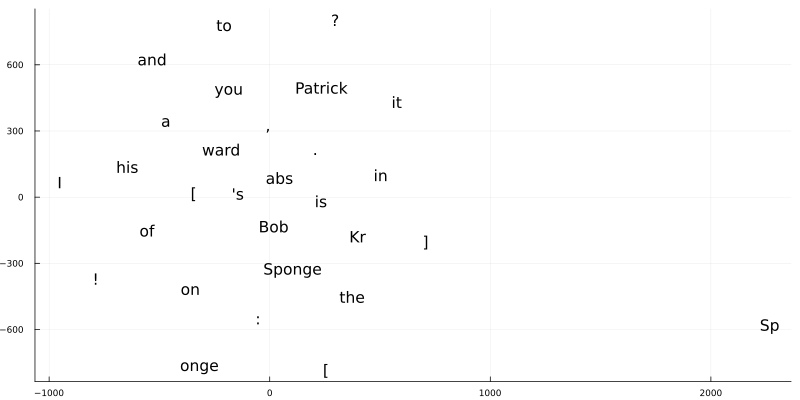

In [44]:
scatter(
    Y[1, :], Y[2, :],
    series_annotations = vocabulary[tks[σ]],
    markeralpha = 0.0, label = "", aspectratio = :equal,
    thickness_scaling = 0.75, size = (800, 400),
)

## Semantische Beziehungen

Wir wollen auch prüfen, ob unsere Worteinbettung semantische Beziehungen algebraisch darstellen kann. 

In [45]:
t1 = tokenizer("SpongeBob")
t2 = tokenizer("sponge")
t3 = tokenizer("star")
t1, t2, t3

([4562, 14221, 18862], [2778, 14221], [7365])

Jetzt nehmen wir `t1`, ziehen `t2` ab und fügen `t3` hinzu. 

In [46]:
V0 = transpose(SpongeGPTv2.head.weight)
v = [mean(V0[:, i], dims = 2) for i in [t1, t2, t3]]
w = v[1] - v[2] + v[3];

Welches Token liegt am Nähesten zu `v`?

Einmal Nähe per Norm gemessen:

In [47]:
norms = [norm(V0[:, i] - w) for i = 1:vocab_size]
idx = sortperm(norms)
for i in 1:10
    j = idx[i]
    nrm = round(norms[j]; digits = 3)
    println(tokenizer.decode([j]), "  (Norm: ", nrm, ")")
end

star  (Norm: 3.256)
Pat  (Norm: 6.661)
 Without  (Norm: 6.818)
Nick  (Norm: 7.023)
Ice  (Norm: 7.265)
seek  (Norm: 7.352)
Narr  (Norm: 7.462)
 Or  (Norm: 7.469)
Fish  (Norm: 7.496)
 six  (Norm: 7.516)


Und einmal per Winkel:

In [48]:
winkel = [acos((V0[:, i] ⋅ w) / (norm(V0[:, i]) * norm(w))) for i = 1:vocab_size]
idx = sortperm(winkel)
for i in 1:10
    j = idx[i]
    theta = round(winkel[j] * 360 / (2*pi); digits = 3)
    println(tokenizer.decode([j]), "  (Winkel: ", theta, "ᵒ)")
end

star  (Winkel: 23.486ᵒ)
 Without  (Winkel: 52.332ᵒ)
seek  (Winkel: 52.719ᵒ)
Pat  (Winkel: 53.673ᵒ)
Nick  (Winkel: 54.325ᵒ)
come  (Winkel: 55.956ᵒ)
OUNT  (Winkel: 56.893ᵒ)
 skins  (Winkel: 57.257ᵒ)
January  (Winkel: 57.397ᵒ)
 Creator  (Winkel: 57.479ᵒ)


## SpongeShakesGPT

Hier ist noch ein kleiner Bonus: 

Wir können unser Modell, SpongeGPT, zusätzlich auf den gesammelten Werken von Shakespeaere trainieren. Das Modell nennen wir dann

$$\textbf{SpongeShakesGPT}$$

Was kommt wohl dabei raus?

In [49]:
##### Laden der Textdaten
ordner = "../text/shakespeare"
R = readdir(ordner)
data = map(R) do filename
    filepath = join([ordner, "/", filename])
    open(filepath) do file
        read(file, String)
    end
end;
text2 = "";
for j = 1:length(data); text2 = join([text2, data[j]]) end;
shakespeare_data = tokenizer(text2);

In [50]:
##### Definition des Modells
SpongeShakesGPTv1 = deepcopy(SpongeGPTv2);

Trainieren des Modells:

In [51]:
batch_size = 32
opt_state = Flux.setup(Flux.Adam(), SpongeShakesGPTv1)
@showprogress for step in 1:50 
    X, Y = erzeuge_batch(shakespeare_data, context_size, batch_size)
    
    L, gradient = Flux.withgradient(SpongeShakesGPTv1) do m
        empirisches_risiko(m(X), Y)
    end
    Flux.update!(opt_state, SpongeShakesGPTv1, gradient[1])
end


Progress: 100%|█████████████████████████████████████████| Time: 0:08:36

In [57]:
prompt = "Patrick loves math and"
SpongeShakesGPTv1(prompt; max_tokens = 200) |> print

Patrick loves math and I’all give their dance ever runs’ Ir could ever since keep a sun still already known with Bazes loudly bleak,
ba.
 evil,
No, of bring
The whats.
sc plays, constantly Fland, or I this mall, the yard...
MSqu ago money?
Bating let your both I refriger Sand subject her Esc, [soio,
Narr.
But don't read, 
flex-We Armorar.
SquidriThe capitals like Sandy fighting that!
F
Ahh Future-n of the guy being turned with squee [Both Charge' it?
 MUST to be for all,
me
shocked,outs cream is do be the worms.
And Twenty to frame my prettitting on the left eyes!
door, And this children earned, by picker along the blended.
Why don't get me yourself... three of Mr BO stories! The worstWow.
l,